## Import Dependencies

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn import preprocessing
import plotly.express as px
from string import ascii_letters

## Read in file
Based on the assessment description, the assumption for this assessment is that train.csv is the only data available that will be used to train and validate the model being built.

Once the model is established, the test.csv will be viewed as 'market data' from real applicants that need to be verified for loan eligibility through my proposed automated process


In [2]:
customer_info = pd.read_csv('../data/train.csv')

## Clean + Assess

In [3]:
# create copy of customer_info for cleaning
customer_info_cleaned = customer_info.copy()

### Remove obviously unecessary columns

In [4]:
# drop Loan_ID column
customer_info_cleaned.drop(columns=['Loan_ID'], inplace=True)

We don't necessarily know enough about the 'Credit_History' column or what it is telling us. So, we will explore the values by ELigible and Not Eligible applicants to understand what the values could mean.

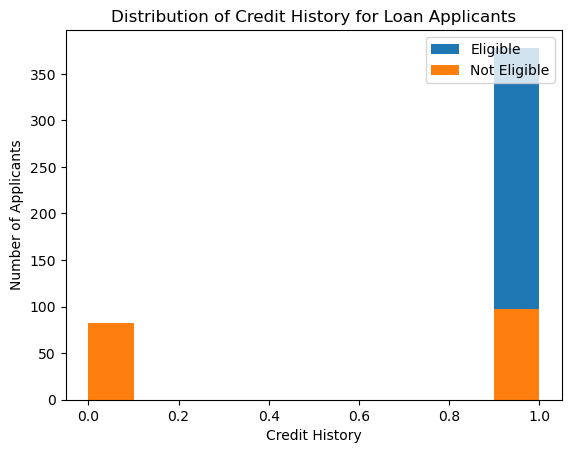

In [5]:
x = customer_info_cleaned['Credit_History'].loc[customer_info_cleaned['Loan_Status']=='Y']
y = customer_info_cleaned['Credit_History'].loc[customer_info_cleaned['Loan_Status']=='N']

plt.hist(x, label='Eligible')
plt.hist(y, label='Not Eligible')
plt.legend(loc='upper right')
plt.title("Distribution of Credit History for Loan Applicants")
plt.ylabel("Number of Applicants")
plt.xlabel("Credit History")
plt.show()

Based on these results, we can see that all eligible loan applicants fall under 1. We can assume this to mean that there is a credit history, whereas 0 denotes no credit history. Based on the division of this value between Eligible and Not Eligible applicants, we will keep this feature for data exploration, summary, and modeling purposes

### Check for null values

In [6]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


We notice that a feature with 614 records indicates a column with no null values. We notice some of our features, like Gender, have values below 614 returned non-null records. However, it does not look like any significant amount of data is missing (ex: >50%)

In [7]:
customer_info.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are a few ways we can handle these nulls. To begin, we will drop any rows with null values for features where the number of null values is < 3% of the total rows in our data.

In [8]:
# create function to drop any rows with nulls values for features where the number of null values is <3% of the total rows in our data
def drop_nas(df):
    for feature in customer_info_cleaned.columns:
        null_sum = customer_info_cleaned[feature].isnull().sum()
        if null_sum < len(customer_info_cleaned) * .03 and null_sum != 0:
            customer_info_cleaned.dropna(subset = [feature], inplace = True)
    return customer_info_cleaned

In [9]:
# run drop_nas on clean copy of customer_info
customer_info_cleaned = drop_nas(customer_info_cleaned)

In [10]:
# verify results
customer_info_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 573 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             573 non-null    object 
 1   Married            573 non-null    object 
 2   Dependents         573 non-null    object 
 3   Education          573 non-null    object 
 4   Self_Employed      542 non-null    object 
 5   ApplicantIncome    573 non-null    int64  
 6   CoapplicantIncome  573 non-null    float64
 7   LoanAmount         553 non-null    float64
 8   Loan_Amount_Term   573 non-null    float64
 9   Credit_History     524 non-null    float64
 10  Property_Area      573 non-null    object 
 11  Loan_Status        573 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 58.2+ KB


Based on the train data, these results are near what we would expect. 

The features that contained <3% of the original 614 rows were 'Gender' (13 null records), Married (3 null records), 'Dependents' (15 null records), and 'Loan_Amount_term' (14 null records). 

We can assume some of the nulls for these features happened within the same record. We still have 573 rows, which we are happy with because we are well over the minimum '10 records per feature' criteria.

In [11]:
# check count for remaining nulls
customer_info_cleaned.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        31
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term      0
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

For the remaining features with Nulls noted above, I will impute their value with a measure of central tendency of their datasets. Before deciding I will look at the spread of the data, while also considering the value in the 'Loan_Status' column.

However, we first need to check that the data types of our features are integers or floats. And if not, change as necessary.

In [12]:
# check dtypes
customer_info_cleaned.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

The columns that are type object are all columns that should have their values encoded.

In [13]:
# create function to encode object values using label_encoder
# leave null values for now until we impute their values
def column_encoder(data):
    # initiate and define label_encoder
    label_encoder = preprocessing.LabelEncoder()
    # user label_encoder on features of interest
    data['Gender'].loc[data['Gender'].notnull()] = label_encoder.fit_transform(data['Gender'].loc[data['Gender'].notnull()])
    data['Married'].loc[data['Married'].notnull()] = label_encoder.fit_transform(data['Married'].loc[data['Married'].notnull()])
    data['Dependents'].loc[data['Dependents'].notnull()] = label_encoder.fit_transform(data['Dependents'].loc[data['Dependents'].notnull()])
    data['Education'].loc[data['Education'].notnull()] = label_encoder.fit_transform(data['Education'].loc[data['Education'].notnull()])   
    data['Self_Employed'].loc[data['Self_Employed'].notnull()] = label_encoder.fit_transform(data['Self_Employed'].loc[data['Self_Employed'].notnull()])
    data['Property_Area'].loc[data['Property_Area'].notnull()] = label_encoder.fit_transform(data['Property_Area'].loc[data['Property_Area'].notnull()])
    data['Loan_Status'].loc[data['Loan_Status'].notnull()] = label_encoder.fit_transform(data['Loan_Status'].loc[data['Loan_Status'].notnull()])
    return data

In [14]:
# run function
customer_info_cleaned = column_encoder(customer_info_cleaned)

C:\Users\asliw\AppData\Local\Temp\ipykernel_32552\4257256577.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Gender'].loc[data['Gender'].notnull()] = label_encoder.fit_transform(data['Gender'].loc[data['Gender'].notnull()])
C:\Users\asliw\AppData\Local\Temp\ipykernel_32552\4257256577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Married'].loc[data['Married'].notnull()] = label_encoder.fit_transform(data['Married'].loc[data['Married'].notnull()])
C:\Users\asliw\AppData\Local\Temp\ipykernel_32552\4257256577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Results of the column_encoder function are: <br>
**'Gender'**: Female = 0, Male = 1 <br>
**'Married'**: No = 0, Yes = 1 <br>
**'Dependents'**: 0 = 0, 1 = 1, 2 = 2, 3+ = 3 <br>
**'Education'**: Graduate = 0, Not Graduate = 1 <br>
**'Self Employed'**: No = 0, Yes = 1 <br>
**'Property_Area'**: Rural = 0, Semi-Urban = 1, Urban = 2 <br>
**'Loan_Status'**: N = 0, Y = 1 <br>

I chose Label Encoding because it encodes in alphabetical order and most of our data only have 2 categories. However, 'Dependents' does actually have an associated order of dependents claimed on a customer application, which the label encoder preserves. Additionally, 'Property Area' has an implied order of population density. Having rural as the lowest value and Urban as highest is a good representation for our data.

In [15]:
# dtypes are still objects, change to int
columns = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
customer_info_cleaned[columns] = customer_info_cleaned[columns].apply(pd.to_numeric, errors='coerce')

In [16]:
# impute null values for 'Self_Employed' based on mode for 'Loan_Status' 1 and 0
# mode for non-eligible applicants
print(customer_info_cleaned['Self_Employed'].loc[customer_info_cleaned['Loan_Status'] == 0].mode())
# mode for eligible applicants
print(customer_info_cleaned['Self_Employed'].loc[customer_info_cleaned['Loan_Status'] == 1].mode())

0    0.0
Name: Self_Employed, dtype: float64
0    0.0
Name: Self_Employed, dtype: float64


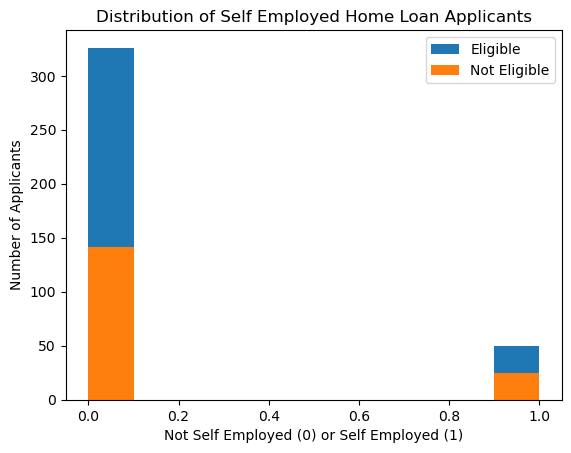

In [17]:
x = customer_info_cleaned['Self_Employed'].loc[customer_info_cleaned['Loan_Status']==1]
y = customer_info_cleaned['Self_Employed'].loc[customer_info_cleaned['Loan_Status']==0]

plt.hist(x, label='Eligible')
plt.hist(y, label='Not Eligible')
plt.legend(loc='upper right')
plt.title("Distribution of Self Employed Home Loan Applicants")
plt.ylabel("Number of Applicants")
plt.xlabel("Not Self Employed (0) or Self Employed (1)")
plt.show()

The mode is 0, or *not self-employed* for both eligible and non-eligible home loan applicants. So, we will impute any nulls for this column with 0.

According to our histogram, only ~17% of the data contains applicants who are Self_Employed.

In [18]:
# for both elibigle and non-eligible loan applicants, change Self_Employed nulls to 0
customer_info_cleaned['Self_Employed'].fillna(0, inplace=True)

Now, we will look at spread for 'LoanAmount' to determine the best measure of central tendency to impute nulls with.

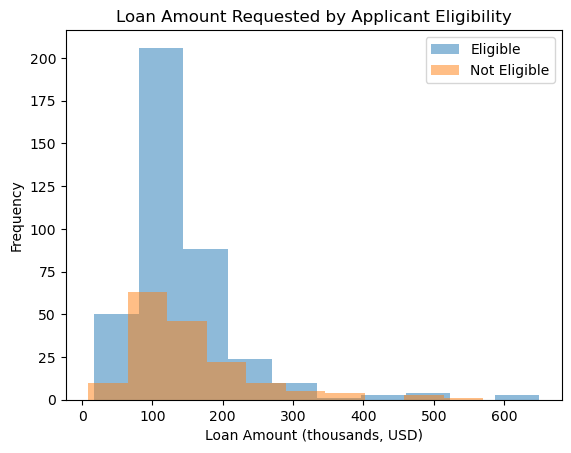

In [19]:
# look at distribution for 'LoanAmount' by eligibility
x = customer_info_cleaned['LoanAmount'].loc[customer_info_cleaned['Loan_Status']==1]
y = customer_info_cleaned['LoanAmount'].loc[customer_info_cleaned['Loan_Status']==0]


plt.hist(x, alpha=0.5,label='Eligible')
plt.hist(y, alpha=0.5,label='Not Eligible')
plt.legend(loc='upper right')
plt.title('Loan Amount Requested by Applicant Eligibility')
plt.xlabel('Loan Amount (thousands, USD)')
plt.ylabel('Frequency')
plt.show()

Key insights from the histograms above are: <br>
- Eligible home loan applicants and Not Eligible applicants have a very similar distribution of loan amounts
- Both histograms are skewed to the right, which likely means their means are higher than is what is actually representative of both groups' home loan requests
- There are clear peaks in the data between 75-150 for both groups

Median will be the best measure of central tendency as this data is skewed and is not categorical.

In [20]:
# determine if we need to break median out by Eligible or Not Eligible groups
loan_amount_median = customer_info_cleaned['LoanAmount'].median()
loan_amount_not_eligible_median = customer_info_cleaned['LoanAmount'].loc[customer_info_cleaned['Loan_Status']==0].median()
loan_amount_eligible_median = customer_info_cleaned['LoanAmount'].loc[customer_info_cleaned['Loan_Status']==1].median()
print(loan_amount_median)
print(loan_amount_not_eligible_median)
print(loan_amount_eligible_median)

128.0
130.5
126.0


The medians are quite close for these groups, so we do not need to break out by Eligible vs Non-Eligible

In [21]:
# impute nulls for 'LoanAmount' with median for Not Eligible and Eligible applicants
# for eligible applicants
loan_amount_eligible_median = customer_info_cleaned['LoanAmount'].median()
customer_info_cleaned['LoanAmount'].fillna(loan_amount_median, inplace=True)

Lastly, for our columns with nulls, we will look at spread for 'Credit_History' to determine the best measure of central tendency to impute nulls with.

At the beginning of this Notebook, when exploring unecessary columns to remove, we reviewed the distribution of this column and discovered the results vary (1 or 0) for only the Not Eligible applicants.

So, we will impute all missing 'Credit_History' values with 1 for Eligible candidates, but review a bit further based on the breakdown of Not Eligible values how to impute their nulls.

In [45]:
# review how many Not Eligible applicants are 1 or 0 for 'Credit_History' for not nulls
not_eligible_credit_history = customer_info_cleaned['Credit_History'].loc[customer_info_cleaned['Loan_Status'] == 0 & customer_info_cleaned['Credit_History'].notnull()]

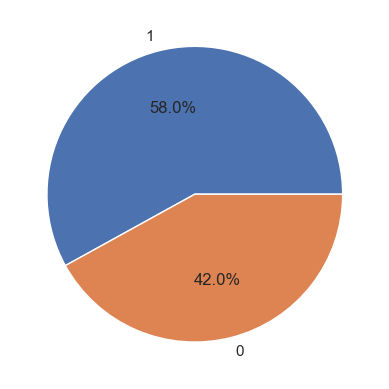

In [104]:
y = not_eligible_credit_history.value_counts()
plt.pie(y, labels=["1",'0'], autopct='%.1f%%')
plt.show()

As suspected from our history for this column at the beginning of our Notebook, 1 is the mode for Not Eligible candidates as well. For existing values, the value 1 exists 16% more, so we will use this value to imput our Not Eligible candidate nulls as well.

In [47]:
# fill all nulls within 'Credit_History' as 1
customer_info_cleaned['Credit_History'].fillna(1, inplace=True)

All of the nulls in our data are now accounted for!

Let's take a lot at outliers in our data.

### Explore Outliers
The following process is relevant for our non categorical variables:
- Understand relationships across our features and spread for each feature <br>
- Hone in on any datasets that have skewed data or potential outliers <br>
    - run box plot for each feature in question <br>
    - run scatterplot based on relationship with other features (if any) to help determine if an erroneous record is valid

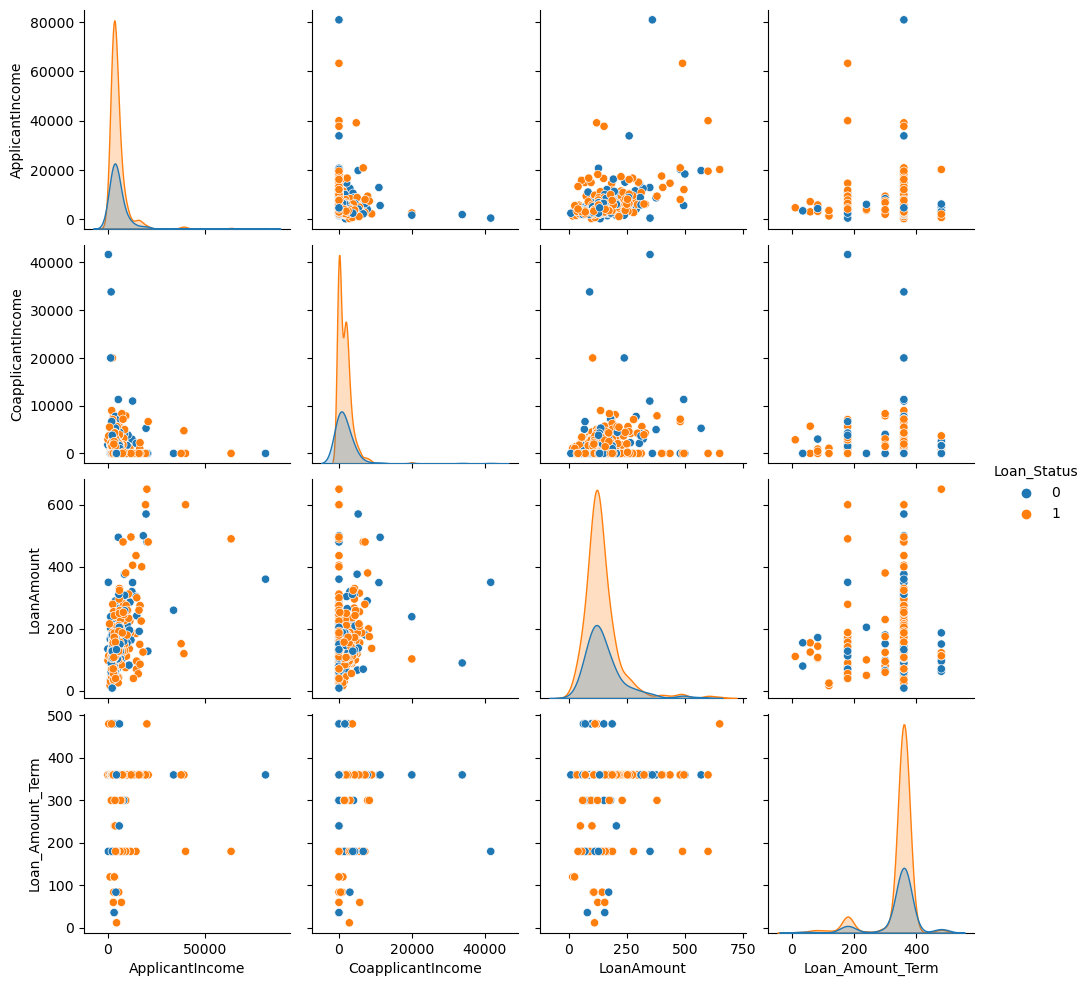

In [83]:
# pairplot for non categorical features
sns.pairplot(customer_info_cleaned, vars = customer_info_cleaned.columns[5:9],hue="Loan_Status")

**'ApplicantIncome'**
- It is unclear if the data refers to annual, quarterly, or monthly income, but based on the histogram, the records center around 5,000, which leads me to believe the data is referring to monthly income. There are some peaks for the Eligible applicants at around 40,000 and 80,000, which will need to be examined further.
- Applicant income has the most obvious relationship with loan amount. The correlation is positive for both eligible and non eligible applicants- the more income, the higher the loan ask. This makes sense as people with higher income can afford more expensive houses

**'CoapplicantIncome'**
- The data peaks at about 2,000 and for Eligible applicants, again at 5,000. This leads me to believe this data is also referring to monthly income
- The data for this feature appears normal for both eligibility categories
- There are no strong relationships between this feature and the others selected

**LoanAmount**
- Loan amount is skewed right for both categories of eligibility. This is not a surprise given our histogram earlier, and outliers will need to be explored
- As discussed, there is a clear positive relationship with this feature and applicant income. There seems to be a slight relationship with loan amount and coapplicant income, but it is not as strong as applicant income and loan amount.

**Loan_Amount_Term**
- This data is clearly broken down into months and is skewed to the left
- The data mostly occurs between 300-400 months, or about 25-33 years. There is another peak between 150-200 months or about 12-16 years.
- I am surprised there is not a strong relationship between applicant income and loan term.

In [67]:
# describe 'ApplicantIncome'
customer_info_cleaned.describe()[['ApplicantIncome']]

,ApplicantIncome
count,573.000000
mean,5328.514834
std,5909.329219
min,150.000000
25%,2876.000000
50%,3812.000000
75%,5815.000000
max,81000.000000


[]

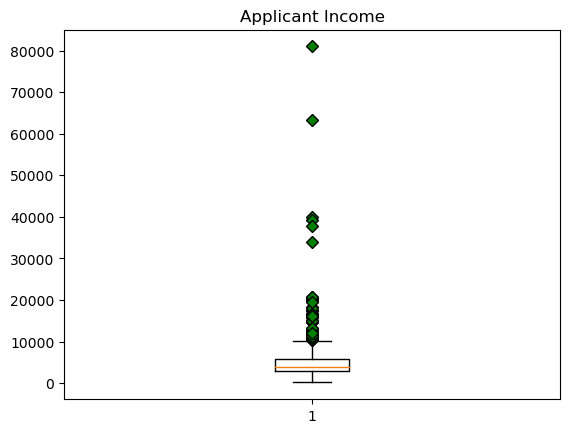

In [85]:
# boxplot for 'ApplicantIncome'
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Applicant Income')
ax1.boxplot(customer_info_cleaned['ApplicantIncome'], flierprops=green_diamond)
plt.plot()

There are some really large values here that seem suspiscious. Values that appear outliers on our graph between 10,000 and 25,000 a month seem more realisitc. 80,000 a month feels more erroneous, but also still extremely possible. Let's do a bivariate boxplot with LoanAmount to see if these outliers occur at the same time as outliers for this column, which could suggest these high values are actually valid.

In [79]:
# create scatterplot of 'ApplicantIncome' and 'LoanAmount'
fig = px.scatter(customer_info_cleaned, x='ApplicantIncome', y='LoanAmount', color='Loan_Status')
fig.show()

       LoanAmount
count  573.000000
mean   145.373473
std     82.635712
min      9.000000
25%    100.000000
50%    128.000000
75%    165.000000
max    650.000000


[]

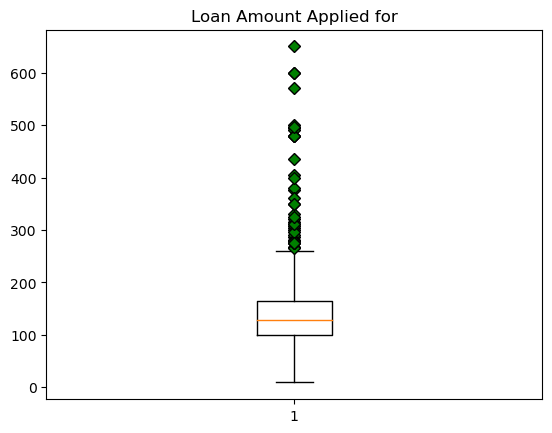

In [81]:
# run description and boxplot of LoanAmount to understand what are considered outliers for this feature

# description
print(customer_info_cleaned.describe()[['LoanAmount']])

#boxplot
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('Loan Amount Applied for')
ax1.boxplot(customer_info_cleaned['LoanAmount'], flierprops=green_diamond)
plt.plot()

In our scatterplot, after the y-axis, if Applicant Income goes above extreme outliers of 30,000+ monthly, the associated Loan are sometimes outliers, but majority above the 50th percentile, with one exception. Given this information and the positive relationship identified between the two variables, there is evidence these are valid data points. Another fact to consider is, even if someone does have high income, it is still reasonable for them to ask for a loan, yes, we would expect the loan ask to potential be higher as we would assume they are buying more valuable assets, but this may not be the case.

Additionally, for other records that are listed as outliers in the boxplot for Applicant Income (but not as extreme as 30k+), like 20,000, there does seem to be a general trend for Loan Amounts requested to be higher (480,000 to 650,000)

Given that none of the values seem truly erroneous, we will keep all values for both columns.

This explanation mainly focused on the case for the outliers in the Applicant Income column. With this information in mind, there are not many application for loans > 300,000. For majority of applications about this amount, applicant income is also above 100,000 USD per year. Using information from articles like this (https://www.linkedin.com/pulse/what-income-needed-500k-mortgage-pierre-carapetian/), it is noted that at least 113,000 USD is required as annual income to afford a 500,000 home loan, which is certainly the case for our graph, even with time from the article and inflation since considered.

There are also recommended ratios of how much folks should put towards their mortgage, but consumers are not always rational spenders.

In [90]:
# run description for 'CoapplicantIncome' to confirm there are no odd numbers
customer_info_cleaned.describe()[['CoapplicantIncome']]

,CoapplicantIncome
count,573.000000
mean,1641.359372
std,3001.139055
min,0.000000
25%,0.000000
50%,1210.000000
75%,2302.000000
max,41667.000000


<AxesSubplot:>

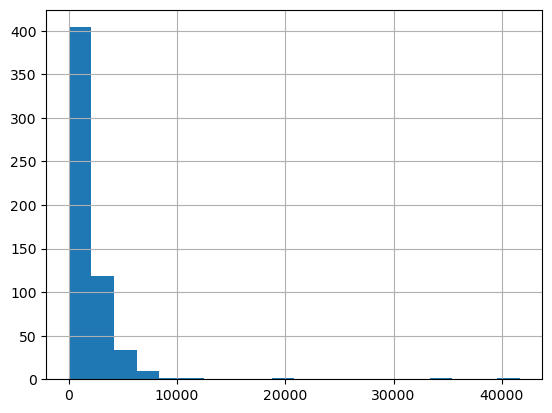

In [91]:
# create histogram for 'CoapplicantIncome'
customer_info_cleaned['CoapplicantIncome'].hist(bins=20)

The data is skewed to the right, with only a potentially erroneous datapoints that are > 10,000 USD

In [94]:
# look at the full records for CoapplicantIncome > 10000
customer_info_cleaned.loc[customer_info_cleaned['CoapplicantIncome'] > 10000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
9,1,1,1,0,0.0,12841,10968.0,349.0,360.0,1.0,1,0
177,1,1,3,0,0.0,5516,11300.0,495.0,360.0,0.0,1,0
402,1,0,0,0,0.0,2500,20000.0,103.0,360.0,1.0,1,1
417,1,1,2,0,1.0,1600,20000.0,239.0,360.0,1.0,2,0
581,1,0,0,0,0.0,1836,33837.0,90.0,360.0,1.0,2,0
600,0,0,3,0,0.0,416,41667.0,350.0,180.0,1.0,2,0


These points all seem valid, there are no odd patterns like all 0s for many of the values. Interestingly enough, for the more wealthy coapplicants, the actual applicants all seem to have no graduated and as the copplicant income rises in these cases, the applicant income generally decreases.

Additionally, when Coapplicant Income is 0, we can assume there was no coapplicant on the home loan application.

In [96]:
# run description for 'Loan_Amount_Term'
customer_info_cleaned.describe()[['Loan_Amount_Term']]

,Loan_Amount_Term
count,573.000000
mean,341.675393
std,65.186012
min,12.000000
25%,360.000000
50%,360.000000
75%,360.000000
max,480.000000


This description of the data is extremely reasonable for loan terms. As we saw in the pairplot, a large majority of loans hover around 360 months (30 years), but there are cases where they are only a year, or even 40 years.

### Rename columns as necessary
Now that we have a better feel for the data, it is clear some of the titles could use cleaning, so the end-user knows how to interpret the numbers

In [99]:
customer_info_cleaned.rename(columns = {'ApplicantIncome':'ApplicantIncome_Monthly', 'CoapplicantIncome':'CoapplicantIncome_Monthly',
                            'LoanAmount':'LoanAmount_Thousands', 'Loan_Amount_Term':'Loan_Amount_Term_Months'}, inplace = True)

In [100]:
customer_info_cleaned

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome_Monthly,CoapplicantIncome_Monthly,LoanAmount_Thousands,Loan_Amount_Term_Months,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0.0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0.0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1.0,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0.0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0.0,6000,0.0,141.0,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0.0,2900,0.0,71.0,360.0,1.0,0,1
610,1,1,3,0,0.0,4106,0.0,40.0,180.0,1.0,0,1
611,1,1,1,0,0.0,8072,240.0,253.0,360.0,1.0,2,1
612,1,1,2,0,0.0,7583,0.0,187.0,360.0,1.0,2,1


## High-level summary- data cleansing

## Feature Analysis

In [189]:
def pie_charts(df,columns):
    for i in columns:
        feature_unique_vals = df[i].unique()
        for x in feature_unique_vals:
            y = df['Loan_Status'].loc[df[i]==x].value_counts()
            colors = ['lightcoral', 'lightskyblue']
            plt.pie(y,labels=y.index, autopct='%.1f%%',colors=colors)
            plt.legend(y.index)
            plt.title(f"Loan eligibility by {i} value {x}")
            plt.show()

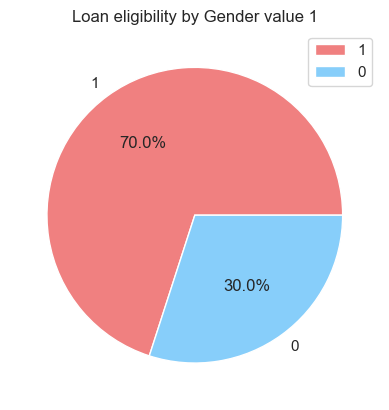

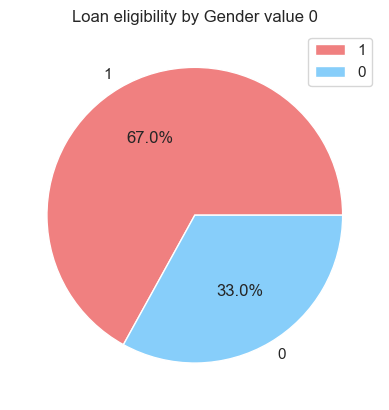

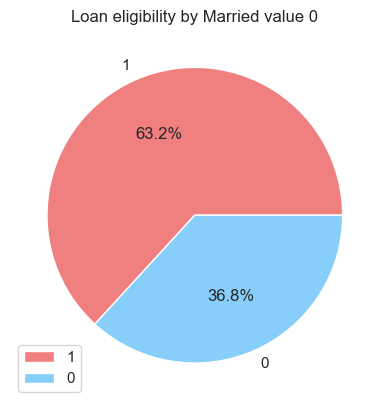

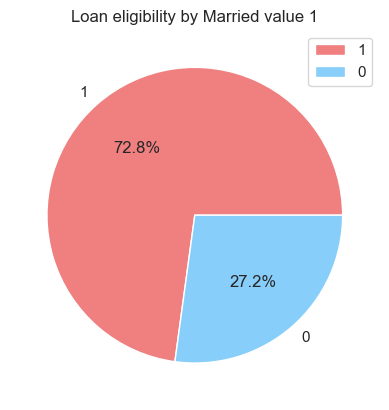

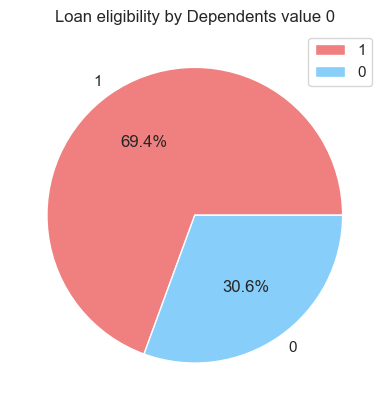

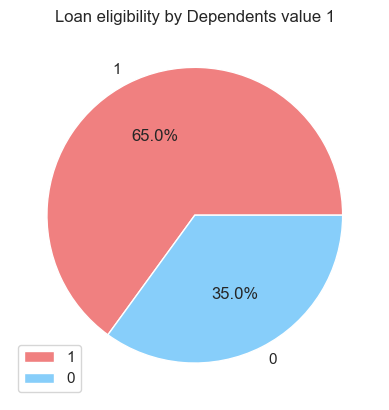

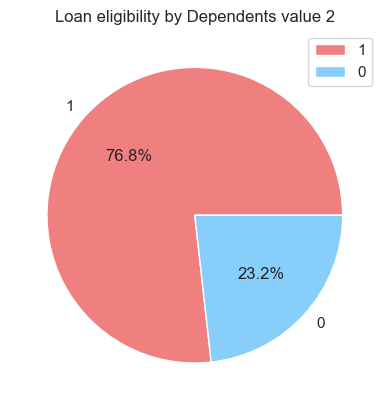

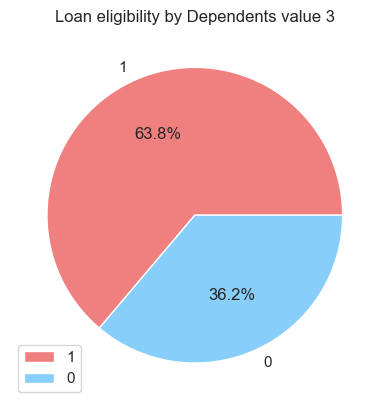

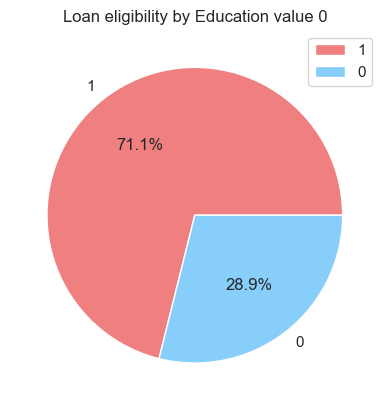

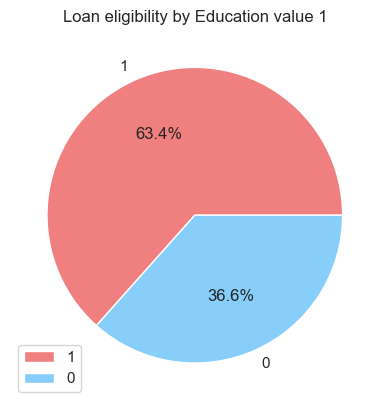

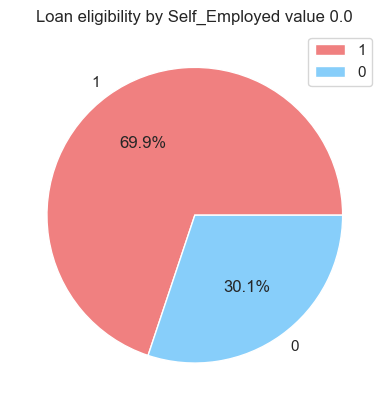

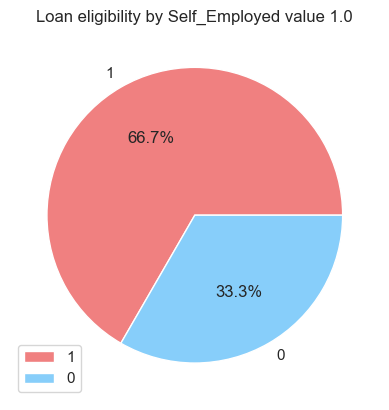

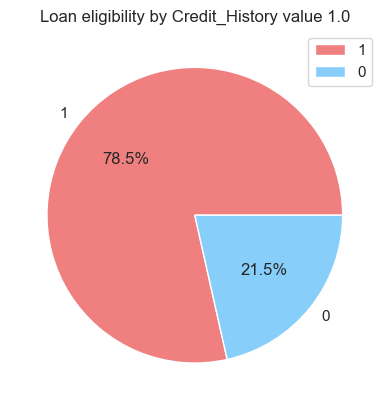

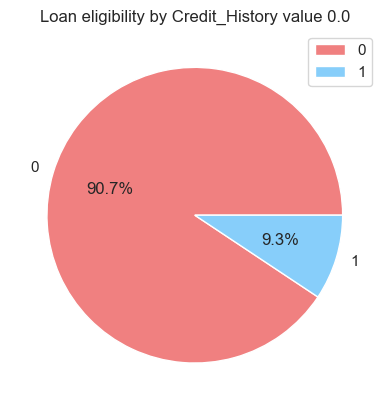

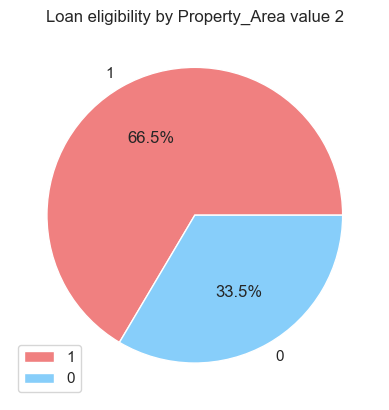

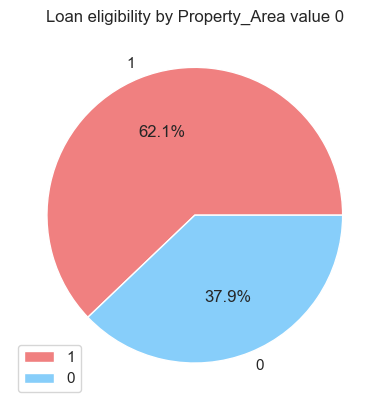

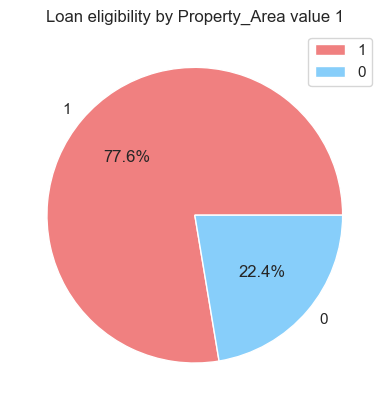

In [190]:
a = list(customer_info_cleaned.columns[0:5])
b = list(customer_info_cleaned.columns[9:11])
c = a+b
pie_charts(customer_info_cleaned, c)

<AxesSubplot:>

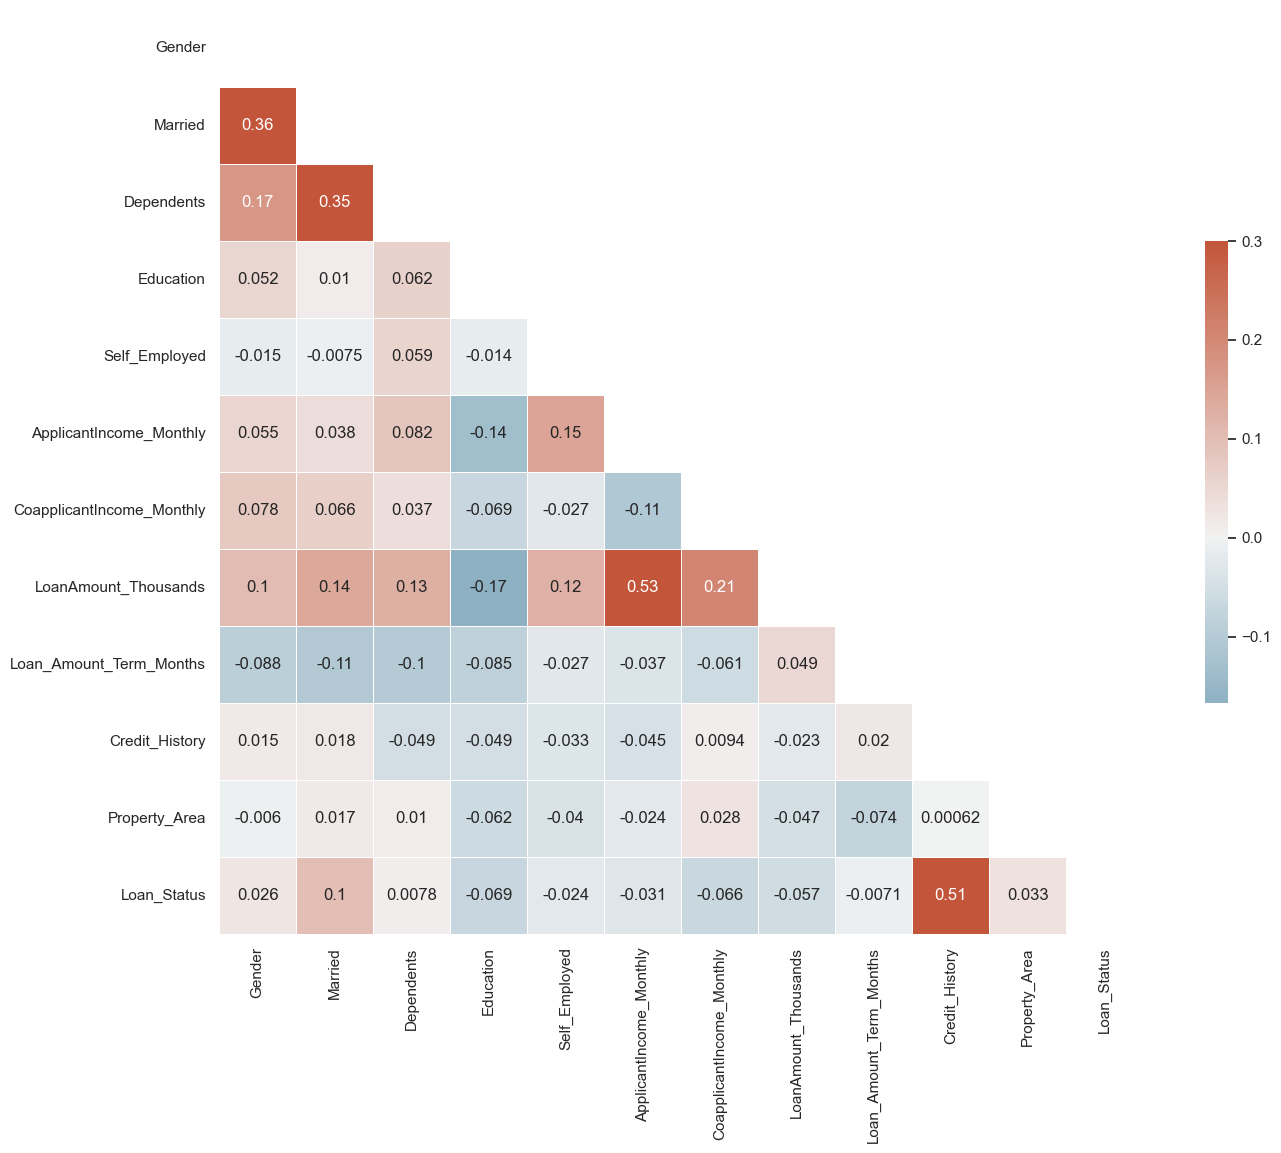

In [102]:
# understand correlatins between all variables
sns.set_theme(style="white")

# Compute the correlation matrix
corr = customer_info_cleaned.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot= True)

As we saw in our pairplot earlier, applicant income and loan amount have a strong positive correlation. It turns out these are the variables with the strongest correlation in the data. Followed closely by credit history and loan status. It makes sense that this correlation is positive because 1 means there is a credit history in our data as well as 1 for loan status means the applicant is eligible.

On a note that speaks more to demographics, we can expect married folks to have higher dependents and if the applicant is a male (1) is strongly related to a higher value for married (1), which means True.

Interesting enough, the factor with the highest correlation to the loan status is credit history, but credit history does not demonstrate a significant correlation with other features. Let's explore the data in different ways to understand what else might contribute to a higher liklihood to be eligible for a home loan.

Based on this information, we realize that applicant income and loan amount are not extremely meaningful on their own, and it will be useful in our modeling to have a feature that is a ratio of applicant income to loan amount.

In [195]:
# create new value for applicant income to loan amount
customer_info_cleaned['Applicant_Income(yearly)_to_Loan_Amount(total)'] = 
((customer_info_cleaned['ApplicantIncome_Monthly']*12) / (customer_info_cleaned['LoanAmount_Thousands']*1000))

In [197]:
# drop ApplicantIncome_Monthly and LoanAmount_Thousands from df
customer_info_cleaned.drop(columns = ['ApplicantIncome_Monthly','LoanAmount_Thousands'], inplace = True)

In [198]:
customer_info_cleaned

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome_Monthly,Loan_Amount_Term_Months,Credit_History,Property_Area,Loan_Status,Applicant_Income(monthly)_to_Loan_Amount(total),Applicant_Income(yearly)_to_Loan_Amount(total)
0,1,0,0,0,0.0,0.0,360.0,1.0,2,1,0.045695,0.548344
1,1,1,1,0,0.0,1508.0,360.0,1.0,0,0,0.035805,0.429656
2,1,1,0,0,1.0,0.0,360.0,1.0,2,1,0.045455,0.545455
3,1,1,0,1,0.0,2358.0,360.0,1.0,2,1,0.021525,0.258300
4,1,0,0,0,0.0,0.0,360.0,1.0,2,1,0.042553,0.510638
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0.0,0.0,360.0,1.0,0,1,0.040845,0.490141
610,1,1,3,0,0.0,0.0,180.0,1.0,0,1,0.102650,1.231800
611,1,1,1,0,0.0,240.0,360.0,1.0,2,1,0.031905,0.382862
612,1,1,2,0,0.0,0.0,360.0,1.0,2,1,0.040551,0.486610


## Hypothesis